In [ ]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split

In [4]:
data_dir = "/kaggle/input/parasite-dataset/parasite-dataset"
filepaths = []
labels = []

folds = os.listdir(data_dir)
for fold in folds:
    if(fold in ['README.md']):
        continue
    foldpath = os.path.join(data_dir, fold)
    filelist = os.listdir(foldpath)
    for file in filelist:
        fpath = os.path.join(foldpath, file)
        
        filepaths.append(fpath)
        labels.append(fold)

# Concatenate data paths with labels into one dataframe
Fseries = pd.Series(filepaths, name= 'filepaths')
Lseries = pd.Series(labels, name='labels')
df = pd.concat([Fseries, Lseries], axis= 1)

In [5]:
df

,filepaths,labels
0,/kaggle/input/parasite-dataset/parasite-datase...,Trypanosome
1,/kaggle/input/parasite-dataset/parasite-datase...,Trypanosome
2,/kaggle/input/parasite-dataset/parasite-datase...,Trypanosome
3,/kaggle/input/parasite-dataset/parasite-datase...,Trypanosome
4,/kaggle/input/parasite-dataset/parasite-datase...,Trypanosome
...,...,...
34293,/kaggle/input/parasite-dataset/parasite-datase...,Leishmania
34294,/kaggle/input/parasite-dataset/parasite-datase...,Leishmania
34295,/kaggle/input/parasite-dataset/parasite-datase...,Leishmania
34296,/kaggle/input/parasite-dataset/parasite-datase...,Leishmania


In [6]:
from sklearn.model_selection import train_test_split
import os, shutil
from tqdm import tqdm

# 1. Train/val/test split
train_df, dummy_df = train_test_split(df, train_size=0.8, shuffle=True, random_state=42, stratify=df['labels'])
val_df, test_df = train_test_split(dummy_df, train_size=0.6, shuffle=True, random_state=42, stratify=dummy_df['labels'])

# 2. Function to save images into ImageFolder structure
def save_split(df, split_name, base_dir="data"):
    split_dir = os.path.join(base_dir, split_name)
    os.makedirs(split_dir, exist_ok=True)

    for _, row in tqdm(df.iterrows(), total=len(df)):
        img_path = row["filepaths"]
        label    = row["labels"]

        # Create class subfolder
        class_dir = os.path.join(split_dir, label)
        os.makedirs(class_dir, exist_ok=True)

        # Copy image
        img_name = os.path.basename(img_path)
        dst_path = os.path.join(class_dir, img_name)

        # To avoid overwriting if filenames repeat across classes
        if not os.path.exists(dst_path):
            shutil.copy(img_path, dst_path)

# 3. Save splits
save_split(train_df, "train", base_dir="data")
save_split(val_df,   "val",   base_dir="data")
save_split(test_df,  "test",  base_dir="data")


100%|██████████| 2744/2744 [00:08<00:00, 314.20it/s]


#### Resize to a fixed input size : 224×224 

#### Convert to Tensor & Normalize (channel-wise mean/std)

#### Light augmentations (to mimic real-world variations but not destroy structure):

    transforms.RandomHorizontalFlip(p=0.5)

    transforms.ColorJitter(brightness=0.1, contrast=0.1)

    transforms.RandomRotation(degrees=10) (small rotations ; parasites can appear at different orientations)

    transforms.GaussianBlur(kernel_size=3, sigma=(0.1, 1.0)) (mild blur simulates focus differences)

In [7]:
from torchvision import transforms
train_transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=10),
    transforms.ColorJitter(brightness=0.1, contrast=0.1),
    transforms.GaussianBlur(kernel_size=3, sigma=(0.1, 1.0)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],  # ImageNet stats
                         std=[0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

In [48]:
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder

train_dataset = ImageFolder("data/train", transform=train_transform)
val_dataset   = ImageFolder("data/val", transform=val_transform)
test_dataset  = ImageFolder("data/test", transform=val_transform)
train_loader  = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
val_loader    = DataLoader(val_dataset  , batch_size=32, shuffle=False, num_workers=4)
test_loader   = DataLoader(test_dataset , batch_size=32, shuffle=False, num_workers=4)

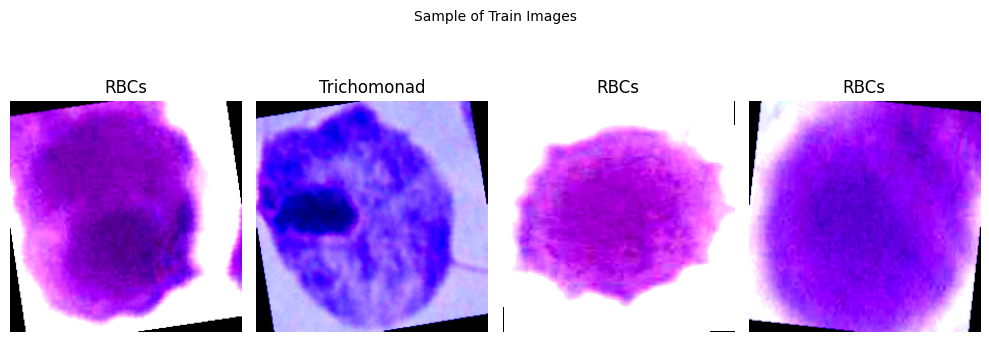

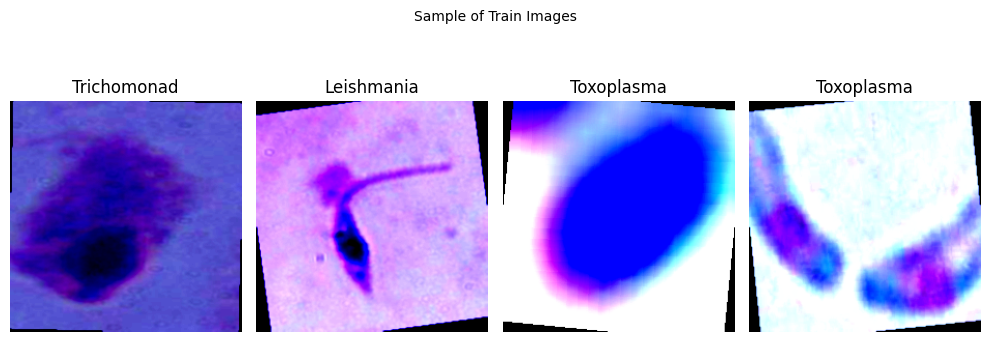

In [9]:
import matplotlib.pyplot as plt

class_names = train_dataset.classes  

def showthem(subset='train'):
    plt.figure(figsize=(10, 4))
    loader = train_loader if subset=='train' else val_loader
    title = 'Sample of Train Images' if subset=='train' else 'Sample of Validation Images'
    data_iter = iter(loader)
    images, labels = next(data_iter)

    for i in range(4):
        plt.subplot(1, 4, i + 1)

        img = images[i].permute(1, 2, 0).numpy()
        
        plt.imshow(img)
        plt.title(class_names[labels[i]])
        plt.axis('off')

    plt.suptitle(title, size=10)
    plt.tight_layout()
    plt.show()

showthem()
showthem("train") 

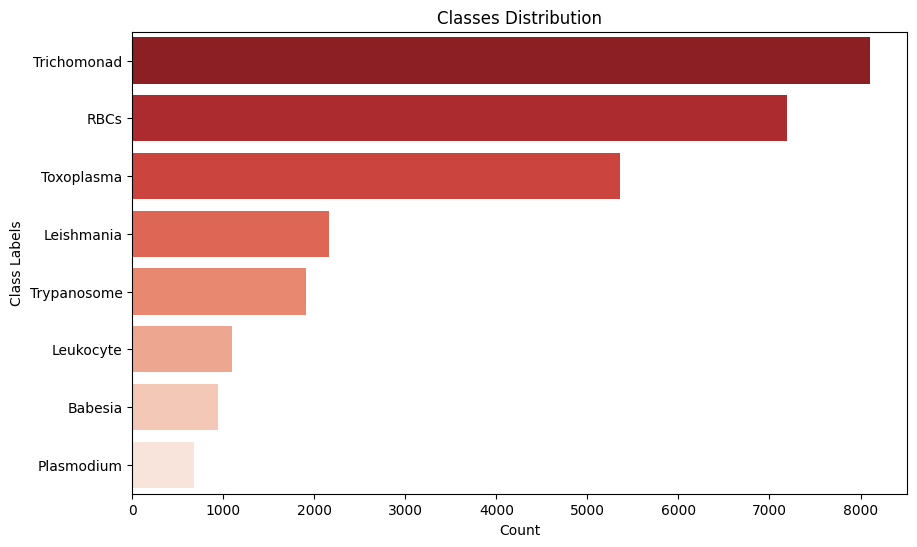

In [10]:
from collections import Counter
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

class_labels = train_dataset.classes  # names of the folders

class_counts = Counter([label for _, label in train_dataset.samples])
dd = pd.DataFrame({
    'labels': class_labels,
    'counts': [class_counts[i] for i in range(len(class_labels))]
})

dd = dd.sort_values(by='counts', ascending=False)
plt.figure(figsize=(10, 6))
sns.barplot(x='counts', y='labels', data=dd, palette='Reds_r')
plt.xlabel('Count')
plt.ylabel('Class Labels')
plt.title('Classes Distribution')
plt.show()

# Model Preparation

In [27]:
from typing import Optional, Tuple
import torch 
import torch.nn as nn

class SigLIPVisionConfig():
    def __init__(
        self,
        hidden_size = 768, ## Embedding size
        inter_size = 3072, ## Linear layer in the feed forward network
        num_hidden_layers = 12,
        num_attention_heads = 12,
        num_channels=3, ## RGB images
        image_size = 224,
        patch_size=16, ## size of the patch (each image will be divided into patches)
        layer_norm_eps=1e-6,
        attention_dropout=0.0,
        num_image_tokens:int=None, ## number of embeddings for each image
        **kwargs
    ):
        super().__init__()
        self.hidden_size = hidden_size
        self.inter_size = inter_size
        self.num_hidden_layers = num_hidden_layers
        self.num_attention_heads = num_attention_heads
        self.num_channels = num_channels
        self.image_size = image_size
        self.patch_size = patch_size
        self.layer_norm_eps = layer_norm_eps
        self.attention_dropout = attention_dropout
        self.num_image_tokens =num_image_tokens


class SigLIPVisionEmbeddings(nn.Module):
    def __init__(self , config:SigLIPVisionConfig):
        super().__init__()
        self.config = config
        self.emb_dim = config.hidden_size
        self.image_size = config.image_size
        self.patch_size = config.patch_size
        
        self.patch_embedding = nn.Conv2d( ## extracting information from the image , patch by patch without overlapping
            in_channels=config.num_channels,
            out_channels=self.emb_dim,
            kernel_size=self.patch_size,
            stride=self.patch_size,
            padding="valid", ## ensure no padding is added
        )
        self.num_patches = (self.image_size // self.patch_size) **2
        self.num_positions = self.num_patches + 1 
        self.Pos_Embedding = nn.Embedding(self.num_positions,self.emb_dim)
        self.register_buffer(
            "position_ids",
            torch.arange(self.num_positions,device=device).expand((1,-1)),
            persistent=False,
        )
        self.cls_token = nn.Parameter(torch.zeros(1,1,self.emb_dim))
        
    def forward(self,pixel_values:torch.Tensor) -> torch.Tensor : 
        batch_size,_, height , width = pixel_values.shape ## (batch_size, channels, height, width) 
        ## (batch_size, channels, height, width) ==> (batch_size, emb_dim, Num_patches_H, Num_patches_W)
        patch_embeddings = self.patch_embedding(pixel_values)
        ## (batch_size, emb_dim, Num_patches_H, Num_patches_W) ==> (batch_size, emb_dim, Num_patches) / Num_patches = Num_patches_H * Num_patches_W
        embeddings = patch_embeddings.flatten(2)
        ## (batch_size, emb_dim, Num_patches) ==> (batch_size, Num_patches, emb_dim)
        embeddings = embeddings.transpose(1,2)
        cls_tkens = self.cls_token.expand(batch_size,-1,-1)
        embeddings = torch.cat((cls_tkens,embeddings),dim=1)
        ## Add positional embedding for each patch
        embeddings = embeddings + self.Pos_Embedding(self.position_ids)
        ## (batch_size, Num_patches, emb_dim)
        return embeddings 

class SigLIPMLP(nn.Module):
    def __init__(self , config:SigLIPVisionConfig):
        super().__init__()
        self.config = config
        self.fc1 = nn.Linear(config.hidden_size , config.inter_size)
        self.fc2 = nn.Linear(config.inter_size , config.hidden_size)

    def forward(self,embeddings) : 
        upper_embeddings = self.fc1(embeddings)
        upper_embeddings = nn.functional.gelu(upper_embeddings,approximate="tanh")
        return self.fc2(upper_embeddings)
            
        
class SigLIPSelfAttention(nn.Module):
    def __init__(self , config:SigLIPVisionConfig):
        super().__init__()
        self.config = config
        self.emb_dim = config.hidden_size
        self.num_heads = config.num_attention_heads
        self.head_dim = self.emb_dim // self.num_heads
        self.scale = self.head_dim ** -0.5 ## (for the scaled dot product attention)
        self.dropout = config.attention_dropout
        
        self.W_k = nn.Linear(self.emb_dim,self.emb_dim) 
        self.W_q = nn.Linear(self.emb_dim,self.emb_dim) 
        self.W_v = nn.Linear(self.emb_dim,self.emb_dim) 
        self.W_o = nn.Linear(self.emb_dim,self.emb_dim) 
    
    def forward(self,embeddings:torch.Tensor) -> Tuple[torch.Tensor,Optional[torch.Tensor]]:
        ## (batch_size, Num_patches, emb_dim)
        batch_size, N_patches, _ = embeddings.size()
        queries = self.W_q(embeddings)
        keys    = self.W_k(embeddings)
        values  = self.W_v(embeddings)
        ## (batch_size, Num_patches, emb_dim) ==> (batch_size, Num_heads, Num_patches, head_dim)
        queries = queries.view(batch_size,N_patches,self.num_heads,self.head_dim).transpose(1,2)
        keys    = keys.view(batch_size,N_patches,self.num_heads,self.head_dim).transpose(1,2)
        values  = values.view(batch_size,N_patches,self.num_heads,self.head_dim).transpose(1,2)
        ## (batch_size, Num_heads, Num_patches, head_dim) @ (batch_size, Num_heads, head_dim, Num_patches)
        attn_weights = (torch.matmul(queries,keys.transpose(2,3))*self.scale) 
        ## attention weights : (batch_size, Num_heads, Num_patches, Num_patches)
        ## softmax , applied by rows
        attn_weights = nn.functional.softmax(attn_weights,dim=-1,dtype=torch.float32).to(queries.dtype)
        attn_weights = nn.functional.dropout(attn_weights,p=self.dropout,training=self.training)
        ## (batch_size, Num_heads, Num_patches, Num_patches) @ (batch_size, Num_heads, Num_patches, head_dim)
        ## attention scores : (batch_size, Num_heads, Num_patches, head_dim)
        attn_scores = torch.matmul(attn_weights,values)
        ## attention scores : (batch_size, Num_heads, Num_patches, head_dim) ==> (batch_size, Num_patches, Num_heads, head_dim)
        attn_scores = attn_scores.transpose(1,2).contiguous()  
        ## (batch_size, Num_patches, Num_heads, head_dim) ==> (batch_size, Num_patches, emb_dim)
        attn_scores = attn_scores.reshape(batch_size,N_patches,self.emb_dim)
        ## Mixing the results of each head with the rest of heads that were calculated separately 
        output = self.W_o(attn_scores)
        
        return output , attn_weights 
    
        
class SigLIPVisionEncoderLayer(nn.Module):
    def __init__(self , config:SigLIPVisionConfig):
        super().__init__()
        self.emb_dim = config.hidden_size
        self.self_attn = SigLIPSelfAttention(config)
        self.layer_norm1 = nn.LayerNorm(self.emb_dim,eps=config.layer_norm_eps)
        self.mlp = SigLIPMLP(config)
        self.layer_norm2 = nn.LayerNorm(self.emb_dim,eps=config.layer_norm_eps)
        
    def forward(self,embeddings:torch.Tensor) -> torch.Tensor :
        ## residual connection (batch_size, Num_patches, emb_dim)
        residual = embeddings
        ## (batch_size, Num_patches, emb_dim) ==> (batch_size, Num_patches, emb_dim)
        embeddings = self.layer_norm1(embeddings)
        ## (batch_size, Num_patches, emb_dim) ==> (batch_size, Num_patches, emb_dim) 
        embeddings, _ = self.self_attn(embeddings)
        ## (batch_size, Num_patches, emb_dim) ==> (batch_size, Num_patches, emb_dim) 
        embeddings = embeddings + residual
        residual = embeddings
        embeddings = self.layer_norm2(embeddings)
        embeddings = self.mlp(embeddings)
        ## (batch_size, Num_patches, emb_dim) ==> (batch_size, Num_patches, emb_dim) 
        embeddings = embeddings + residual
        
        return embeddings
    
    
    
class SigLIPVisionEncoder(nn.Module):
    def __init__(self,config):
        super().__init__()
        self.config=config
        self.layers = nn.ModuleList(
            [SigLIPVisionEncoderLayer(self.config) for _ in range(config.num_hidden_layers)]
        )
    def forward(self,embeddings:torch.Tensor) -> torch.Tensor:
        for layer in self.layers : 
            embeddings = layer(embeddings)
        return embeddings            
    
    

class SigLIPVisionTransformer(nn.Module):
    def __init__(self , config:SigLIPVisionConfig):
        super().__init__()
        self.config = config
        emb_dim = config.hidden_size
        self.embeddings = SigLIPVisionEmbeddings(config) ## extract patches
        self.encoder = SigLIPVisionEncoder(config)       ## encoder of the transformer (series of layers)
        self.post_layerNorm = nn.LayerNorm(emb_dim,eps=config.layer_norm_eps)
    def forward(self,pixel_values:torch.Tensor) -> torch.Tensor:
        ## pixel values : (batch_size, channels, height, width) ==> (batch_size, Num_patches, emb_dim)
        embeddings = self.embeddings(pixel_values)
        
        encoded_embeddings = self.encoder(embeddings) ## Convolution , split into patches , flattening + Positional Encoding
        encoded_embeddings = self.post_layerNorm(encoded_embeddings) 
        return encoded_embeddings
        
        
class SigLIPVisionModel(nn.Module):
    def __init__(self , config:SigLIPVisionConfig):
        super().__init__()
        self.config = config
        self.VisionModel = SigLIPVisionTransformer(config)
        
    def forward(self,pixel_values) -> Tuple:
        ## (batch_size, channels , height ,width) ==> (batch_size, num_patches, emb_dim)
        return self.VisionModel(pixel_values)
        

In [28]:
class SigLIPForImageClassification(nn.Module):
    def __init__(self, config: SigLIPVisionConfig, num_classes: int):
        super().__init__()
        self.vision_model = SigLIPVisionTransformer(config)
        self.classifier = nn.Linear(config.hidden_size, num_classes)

    def forward(self, pixel_values: torch.Tensor) -> torch.Tensor:
        embeddings = self.vision_model(pixel_values)  # (B, num_patches+1, emb_dim)
        cls_embedding = embeddings[:, 0]  # take [CLS] token
        logits = self.classifier(cls_embedding)
        return logits

In [29]:
config = SigLIPVisionConfig()
model = SigLIPForImageClassification(config, num_classes=10).to("cpu")

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=3e-4)

In [30]:
model

SigLIPForImageClassification(
  (vision_model): SigLIPVisionTransformer(
    (embeddings): SigLIPVisionEmbeddings(
      (patch_embedding): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16), padding=valid)
      (Pos_Embedding): Embedding(197, 768)
    )
    (encoder): SigLIPVisionEncoder(
      (layers): ModuleList(
        (0-11): 12 x SigLIPVisionEncoderLayer(
          (self_attn): SigLIPSelfAttention(
            (W_k): Linear(in_features=768, out_features=768, bias=True)
            (W_q): Linear(in_features=768, out_features=768, bias=True)
            (W_v): Linear(in_features=768, out_features=768, bias=True)
            (W_o): Linear(in_features=768, out_features=768, bias=True)
          )
          (layer_norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
          (mlp): SigLIPMLP(
            (fc1): Linear(in_features=768, out_features=3072, bias=True)
            (fc2): Linear(in_features=3072, out_features=768, bias=True)
          )
          (layer_norm2

In [31]:
train_losses = []
val_losses = []
train_accs = []
val_accs = []
val_f1s = []

from sklearn.metrics import f1_score
from tqdm import tqdm

In [35]:
from torch.optim.lr_scheduler import StepLR

scheduler = StepLR(optimizer, step_size=5, gamma=0.5)  # halve LR every 5 epochs


num_epochs = 10 
model.to(device)
for epoch in range(num_epochs):
    model.train()
    running_loss = 0
    correct = 0
    total = 0
    
    for imgs, labels in tqdm(train_loader,desc=f"Epoch [{epoch+1}/{num_epochs}]", leave=False):
        imgs, labels = imgs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * imgs.size(0)
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)
    scheduler.step()
    epoch_loss = running_loss / total
    epoch_acc = correct / total
    train_losses.append(epoch_loss)
    train_accs.append(epoch_acc)
    
    # --- Validation ---
    model.eval()
    val_running_loss = 0
    val_correct = 0
    val_total = 0
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for imgs, labels in tqdm(val_loader,desc=f"Epoch [{epoch+1}/{num_epochs}]", leave=False):
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            val_running_loss += loss.item() * imgs.size(0)
            
            _, preds = torch.max(outputs, 1)
            val_correct += (preds == labels).sum().item()
            val_total += labels.size(0)
            
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    val_loss = val_running_loss / val_total
    val_acc = val_correct / val_total
    val_losses.append(val_loss)
    val_accs.append(val_acc)
    
    val_f1 = f1_score(all_labels, all_preds, average='weighted')
    val_f1s.append(val_f1)
    
    print(f"Epoch {epoch+1}/{num_epochs} | Train Loss: {epoch_loss:.4f} | Val Loss: {val_loss:.4f} | Val F1: {val_f1:.4f}")


Epoch 1/10 | Train Loss: 0.2436 | Val Loss: 0.3581 | Val F1: 0.8651


Epoch 2/10 | Train Loss: 0.2001 | Val Loss: 0.1483 | Val F1: 0.9471


Epoch 3/10 | Train Loss: 0.1555 | Val Loss: 0.1204 | Val F1: 0.9628


Epoch 4/10 | Train Loss: 0.1363 | Val Loss: 0.2558 | Val F1: 0.9147


Epoch 5/10 | Train Loss: 0.1606 | Val Loss: 0.1261 | Val F1: 0.9517


Epoch 6/10 | Train Loss: 0.1024 | Val Loss: 0.0935 | Val F1: 0.9686


Epoch 7/10 | Train Loss: 0.0805 | Val Loss: 0.1057 | Val F1: 0.9647


Epoch 8/10 | Train Loss: 0.0852 | Val Loss: 0.0747 | Val F1: 0.9775


Epoch 9/10 | Train Loss: 0.0665 | Val Loss: 0.0826 | Val F1: 0.9705


Epoch 10/10 | Train Loss: 0.0693 | Val Loss: 0.1635 | Val F1: 0.9449


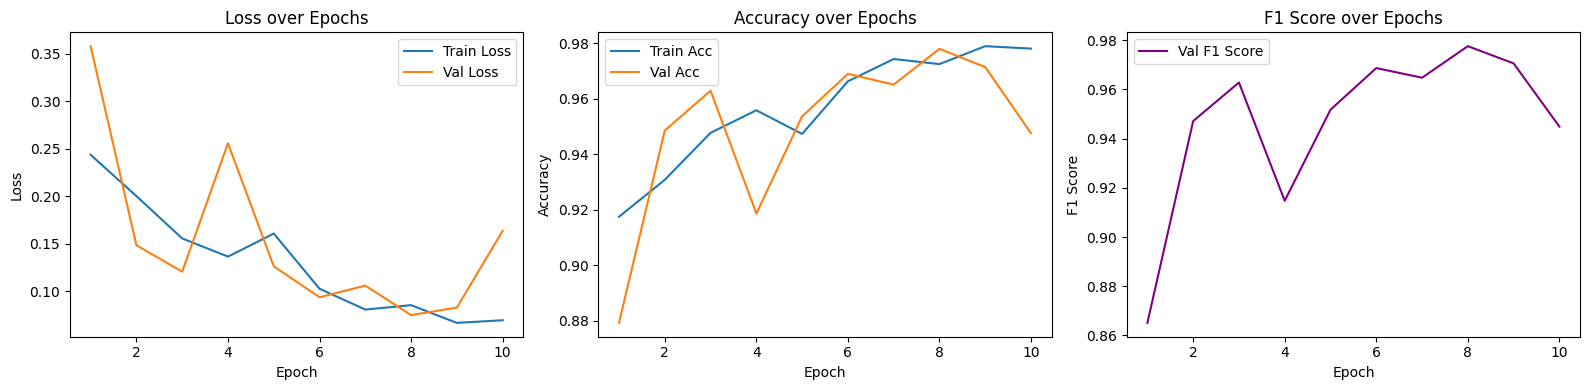

In [36]:
import matplotlib.pyplot as plt

epochs = range(1, num_epochs+1)

plt.figure(figsize=(16,4))

plt.subplot(1,3,1)
plt.plot(epochs, train_losses, label='Train Loss')
plt.plot(epochs, val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss over Epochs')
plt.legend()

plt.subplot(1,3,2)
plt.plot(epochs, train_accs, label='Train Acc')
plt.plot(epochs, val_accs, label='Val Acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy over Epochs')
plt.legend()

plt.subplot(1,3,3)
plt.plot(epochs, val_f1s, label='Val F1 Score', color='purple')
plt.xlabel('Epoch')
plt.ylabel('F1 Score')
plt.title('F1 Score over Epochs')
plt.legend()

plt.tight_layout()
plt.show()


In [54]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import numpy as np

# Binarize labels for multi-class
n_classes = len(class_labels)
y_true = label_binarize(all_labels, classes=range(n_classes))
y_score = torch.nn.functional.softmax(torch.tensor(all_preds_logits), dim=1).numpy()  # logits before argmax

plt.figure(figsize=(8,6))
for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_true[:, i], y_score[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"Class {i} (AUC = {roc_auc:.2f})")

plt.plot([0,1], [0,1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()


NameError: name 'all_preds_logits' is not defined

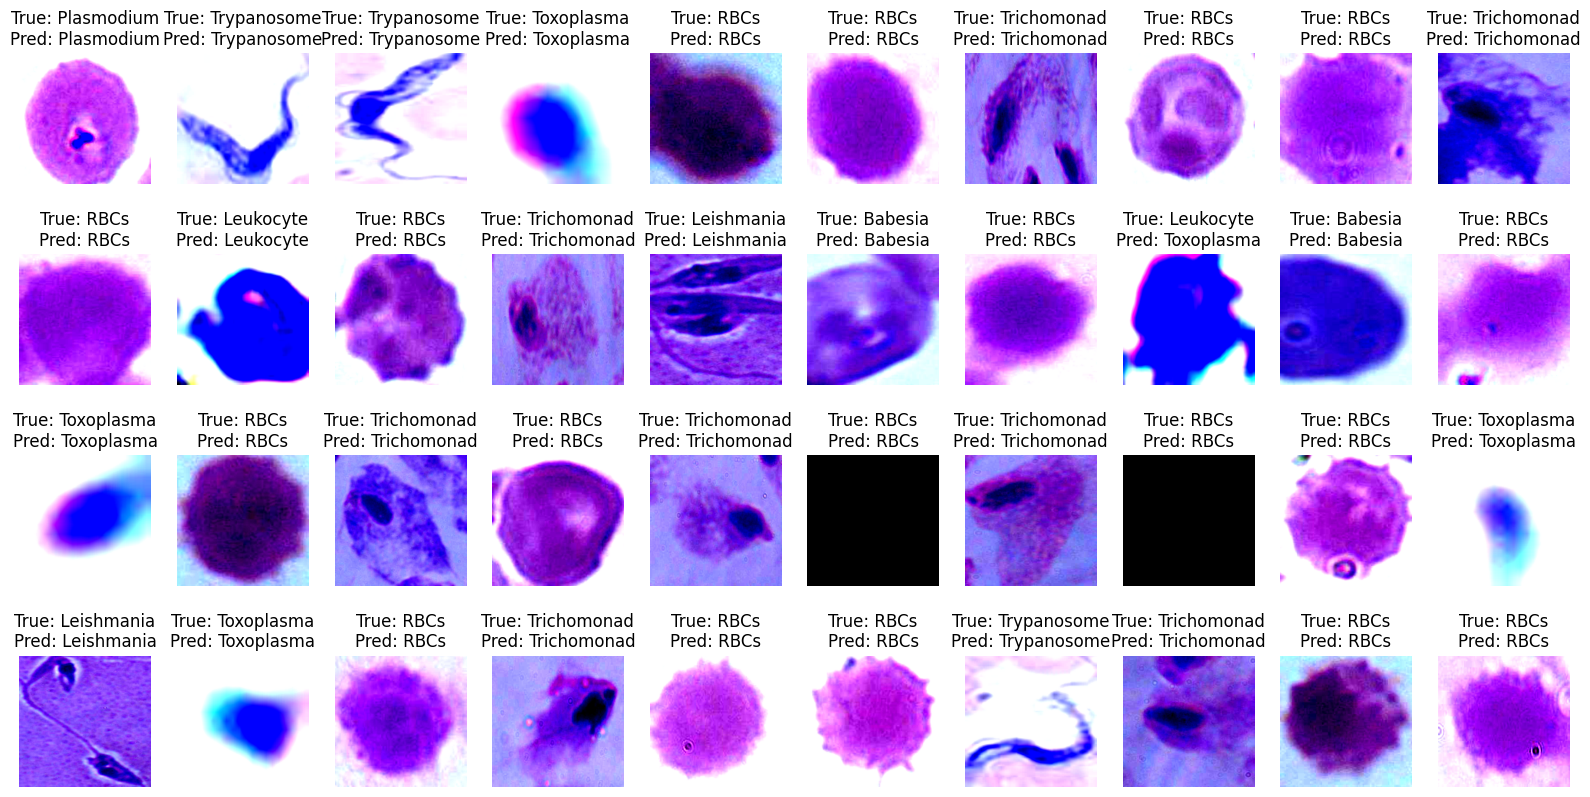

In [66]:
import torch
import matplotlib.pyplot as plt
import random

# Set model to evaluation
model.eval()

# Mapping from indices to class names
idx_to_class = {v: k for k, v in test_dataset.class_to_idx.items()}

# Pick a few random indices
num_samples = 40
indices = random.sample(range(len(test_dataset)), num_samples)

plt.figure(figsize=(20, 10))

for i, idx in enumerate(indices):
    img, true_label_idx = test_dataset[idx]
    
    # Move to batch format (1, C, H, W)
    input_tensor = img.unsqueeze(0).to("cuda")  # or "cuda" if using GPU
    with torch.no_grad():
        output = model(input_tensor)
        predicted_label_idx = torch.argmax(output, dim=1).item()
    
    # Convert numeric indices to class names
    true_label = idx_to_class[true_label_idx]
    predicted_label = idx_to_class[predicted_label_idx]
    
    plt.subplot(4, num_samples//4, i + 1)
    img_np = img.permute(1, 2, 0).numpy()
    plt.imshow(img_np)
    plt.title(f"True: {true_label}\nPred: {predicted_label}")
    plt.axis("off")

plt.show()
